In [324]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import emcee
import corner

import quantumsolver as qs

# help(qs.fewnucleonEmulator)

# Vectorized version of the fewnucleonEmulator
vfewnucleonEmulator = np.vectorize(qs.fewnucleonEmulator)

In [379]:
# LaTeX font
plt.style.use('default')
plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 14
plt.rcParams['font.size'] = font_size

cD_grid = np.linspace(-2.5, 2.5, 1500)
cE_grid = np.linspace(-1., 1., 1500)

# # Create a 2-dimensional grid
cD_eval, cE_eval = np.meshgrid(cD_grid, cE_grid)

#cD, cE = np.mgrid[-2.:2.:.01, -1:1:.005]
#grid = np.dstack((cD, cE)).reshape(-1, 2)
#print(grid.shape)


In [380]:
efterror = True
y_E4He, sigma_E4He = -28.296, 0.005
y_Rp4He, sigma_Rp4He = 1.4552, 0.0062
y_E3H, sigma_E3H = -8.482, 0.015
y_fT3H, sigma_fT3H = 1129.6, 3.

def log_prior(params):

    cD, cE = params[0], params[1]
    cD_mu = 0.
    cD_sigma = 5
    cE_mu = 0.
    cE_sigma = 5

    return (stats.norm.logpdf(cD, loc=cD_mu, scale=cD_sigma) + 
            stats.norm.logpdf(cE, loc=cE_mu, scale=cE_sigma)) 

def log_likelihood(params, data, y_i, sigma, efterror):
    cD, cE = params[:,0], params[:,1]

    if efterror:
        sigma = np.sqrt(sigma**2 + (1 * 0.33**4 * y_i)**2/(1 - 0.33**2))

    return stats.norm.logpdf(y_i, loc=data, scale=sigma)

def log_posterior(params, data, y_i, sigma, efterror):

    return log_prior(params) + log_likelihood(params, data, y_i, sigma, efterror)

E4He_eval, Rp4He_eval, _, _, E3H_eval, _, fT3H_eval = vfewnucleonEmulator(cD_eval, cE_eval)

log_post_values_Rp4He = log_posterior(np.array([cD_eval, cE_eval]), Rp4He_eval, y_Rp4He, sigma_Rp4He, True)
log_post_values_E3H = log_posterior(np.array([cD_eval, cE_eval]), E3H_eval, y_E3H, sigma_E3H, True)
log_post_values_fT3H = log_posterior(np.array([cD_eval, cE_eval]), fT3H_eval, y_fT3H, sigma_fT3H, True)
log_post_values_E4He = log_posterior(np.array([cD_eval, cE_eval]), E4He_eval, y_E4He, sigma_E4He, True)

log_post_values_Rp4He_no_error = log_posterior(np.array([cD_eval, cE_eval]), Rp4He_eval, y_Rp4He, sigma_Rp4He, False)
log_post_values_E3H_no_error = log_posterior(np.array([cD_eval, cE_eval]), E3H_eval, y_E3H, sigma_E3H, False)
log_post_values_fT3H_no_error = log_posterior(np.array([cD_eval, cE_eval]), fT3H_eval, y_fT3H, sigma_fT3H, False)
log_post_values_E4He_no_error = log_posterior(np.array([cD_eval, cE_eval]), E4He_eval, y_E4He, sigma_E4He, False)

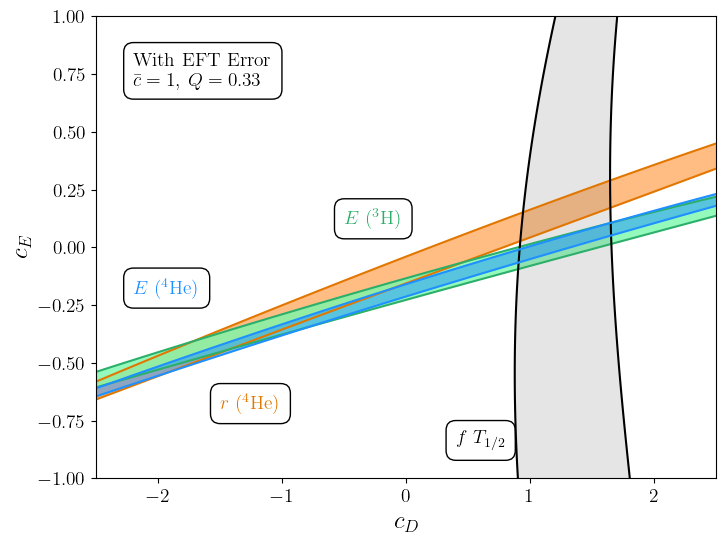

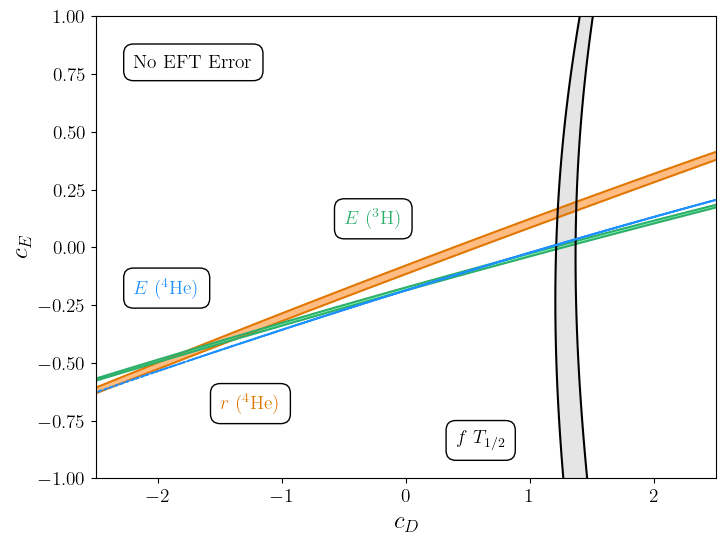

In [381]:
def contour_levels(grid):
    """Compute 1, 2, 3-sigma contour levels for a gridded 2D pdf"""
    _sorted = np.sort(grid.ravel())[::-1]
    pct = np.cumsum(_sorted) / np.sum(_sorted)
    cutoffs = np.searchsorted(pct, np.array([0.68, 0.95, 0.997]) ** 2)
    cutoffs = np.searchsorted(pct, np.array([0.75]) ** 2)
    return np.sort(_sorted[cutoffs])

def post_plot(ax, colors, alpha, colors_contour, log_post_values):
    post_values = np.exp(log_post_values)
    std = np.std(post_values)

    # mean_est, cov_est = stats.multivariate_normal.fit(post_values.reshape(-1,2))

    # pdf_norm = post_values / np.sum(post_values)
    # cdf = np.cumsum(pdf_norm)

    # lim_68_low = post_values.flatten()[np.searchsorted(cdf, 0.2)]
    # lim_68_high = post_values.flatten()[np.searchsorted(cdf, 0.68)]
    # lim_68 = np.mean([lim_68_low, lim_68_high])

    levels = contour_levels(post_values)
    levels = [levels[0], np.max(post_values)]

    contour_lines = ax.contourf(cD_grid, cE_grid, post_values, levels=levels, colors=colors, alpha=alpha)
    ax.contour(contour_lines, colors=colors_contour)

fig1, ax1 = plt.subplots(1, 1, figsize=(8, 6))
post_plot(ax1, colors='#ffb16d', alpha=0.85, colors_contour='#e17701', log_post_values=log_post_values_Rp4He)
post_plot(ax1, colors='#7af9ab', alpha=0.8, colors_contour='#2baf6a', log_post_values=log_post_values_E3H)
post_plot(ax1, colors='gray', alpha=0.2, colors_contour='black', log_post_values=log_post_values_fT3H)
post_plot(ax1, colors='dodgerblue', alpha=0.5, colors_contour='dodgerblue', log_post_values=log_post_values_E4He)

fig2, ax2 = plt.subplots(1, 1, figsize=(8, 6))
post_plot(ax2, colors='#ffb16d', alpha=0.85, colors_contour='#e17701', log_post_values=log_post_values_Rp4He_no_error)
post_plot(ax2, colors='#7af9ab', alpha=0.8, colors_contour='#2baf6a', log_post_values=log_post_values_E3H_no_error)
post_plot(ax2, colors='gray', alpha=0.2, colors_contour='black', log_post_values=log_post_values_fT3H_no_error)
post_plot(ax2, colors='dodgerblue', alpha=0.5, colors_contour='dodgerblue', log_post_values=log_post_values_E4He_no_error)

def customizer(ax, efterror=False):
    for txt in ax.texts[1:]:
        txt.set_visible(False)
        ax.texts[1:].remove(txt)

    ax.set_xlabel('$c_D$', fontsize=font_size+4)
    ax.set_ylabel('$c_E$', fontsize=font_size+4)
    ax.text(0.4, -0.85, '$f$ $T_{1/2}$', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    ax.text(-1.5, -0.7, '$r$ ($^4$He)', color='#e17701', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    ax.text(-0.5, .1, '$E$ ($^3$H)', color='#2baf6a', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    ax.text(-2.2, -0.2, '$E$ ($^4$He)', color='dodgerblue', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)

    if efterror:
        ax.text(-2.2, 0.7, 'With EFT Error \n $\\bar{c}=1$, $Q=0.33$', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    else:
        ax.text(-2.2, 0.78, 'No EFT Error', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)

save = False

#for ax in [ax1, ax2]:

customizer(ax1, efterror=True)
customizer(ax2, efterror=False)

fig = ax.get_figure()
if efterror and save:
    fig.savefig('figs/constraints_EFT_exp_new.pdf', bbox_inches='tight')
elif save:
    fig.savefig('figs/constraints_noEFT_exp_new.pdf', bbox_inches='tight')


In [320]:
# def constraint_plotter(cD_eval, cE_eval, efterror=False):

#     E4He_eval, Rp4He_eval, _, _, E3H_eval, _, fT3H_eval = vfewnucleonEmulator(cD_eval, cE_eval)

#     fig, ax = plt.subplots()

#     x = 1

#     mean_E4He = -28.296
#     mean_Rp4He = 1.4552
#     mean_E3H = -8.482 
#     mean_fT3H = 1129.6

#     sigma_E3H = 0.015
#     sigma_E4He = 0.005
#     sigma_Rp4He = 0.0062
#     sigma_fT3H = 3.

#     if efterror:
#         sigma_E3H = np.sqrt(0.015 + (1 * 0.33**4 * -8.482)**2/(1 - 0.33**2))
#         sigma_E4He = np.sqrt(0.005 + (1 * 0.33**4 * -28.296)**2/(1 - 0.33**2))
#         sigma_Rp4He = np.sqrt(0.0062 + (1 * 0.33**4 * 1.4552)**2/(1 - 0.33**2))
#         sigma_fT3H = np.sqrt(3. + (1 * 0.33**4 * 1129.6)**2/(1 - 0.33**2))
#         ax.text(-2.2, 0.7, 'With EFT Error \n $\\bar{c}=1$, $Q=0.33$', color='black', 
#         bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
#     else:
#         ax.text(-2.2, 0.78, 'No EFT Error', color='black', 
#         bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)

#     cs = ax.contourf(cD_eval, cE_eval, fT3H_eval, levels=[mean_fT3H-x*sigma_fT3H, mean_fT3H+x*sigma_fT3H], colors='gray', alpha=0.2)
#     contour_lines = ax.contour(cs, levels=cs.levels[:3], colors='black')
#     cs = ax.contourf(cD_eval, cE_eval, Rp4He_eval, levels=[mean_Rp4He-x*sigma_Rp4He, mean_Rp4He+x*sigma_Rp4He], colors='#ffb16d', alpha=0.85)
#     contour_lines = ax.contour(cs, levels=cs.levels[:3], colors='#e17701')
#     cs = ax.contourf(cD_eval, cE_eval, E3H_eval, levels=[mean_E3H-x*sigma_E3H, mean_E3H+x*sigma_E3H], colors='#7af9ab', alpha=0.8)
#     contour_lines = ax.contour(cs, levels=cs.levels[:3], colors='#2baf6a', linestyles='-')
#     cs = ax.contourf(cD_eval, cE_eval, E4He_eval, levels=[mean_E4He-x*sigma_E4He, mean_E4He+x*sigma_E4He], colors='dodgerblue', alpha=0.5)
#     contour_lines = ax.contour(cs, levels=cs.levels[:3], colors='dodgerblue', linestyles='-')

#     return ax

In [333]:
sigma_E3H = np.sqrt(0.015**2 + (1 * 0.33**4 * -8.482)**2/(1 - 0.33**2))
sigma_E4He = np.sqrt(0.005**2 + (1 * 0.33**4 * -28.296)**2/(1 - 0.33**2))
sigma_Rp4He = np.sqrt(0.0062**2 + (1 * 0.33**4 * 1.4552)**2/(1 - 0.33**2))
sigma_fT3H = np.sqrt(3.**2 + (1 * 0.33**4 * 1129.6)**2/(1 - 0.33**2))

def log_prior(params):
    params = params.reshape(-1, 2)
    cD, cE = params[:,0], params[:,1]
    cD_mu = 0.
    cD_sigma = 5
    cE_mu = 0.
    cE_sigma = 5

    return (stats.norm.logpdf(cD, loc=cD_mu, scale=cD_sigma) + 
            stats.norm.logpdf(cE, loc=cE_mu, scale=cE_sigma)) 

def log_likelihood(params, data_set):
    params = params.reshape(-1, 2)
    cD, cE = params[:,0], params[:,1]
    E4He, Rp4He, _, _, E3H, _, fT3H = vfewnucleonEmulator(cD, cE)

    if len(data_set) == 2:
        return (np.sum(stats.norm.logpdf(-28.296, E4He, sigma_E4He)) + 
                np.sum(stats.norm.logpdf(1.4552, Rp4He, sigma_Rp4He)))
    elif len(data_set) == 4:
        return (stats.norm.logpdf(-28.296, E4He, sigma_E4He) +
                stats.norm.logpdf(1.4552, Rp4He, sigma_Rp4He) +
                stats.norm.logpdf(-8.482, E3H, sigma_E3H) +
                stats.norm.logpdf(1129.6, fT3H, sigma_fT3H))

def log_posterior(params, data_set):
    return log_prior(params) + log_likelihood(params, data_set)

cD = np.random.normal(0., 5, 25)
cE = np.random.normal(0., 5, 25)

pos = np.vstack((cD, cE))
nwalkers, ndim = pos.T.shape

E4He, Rp4He, _, _, E3H, _, fT3H = vfewnucleonEmulator(cD, cE)

#sampler_2 = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_posterior, args=[(E4He, Rp4He)])
sampler_4 = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_posterior, args=[(E4He, Rp4He, E3H, fT3H)])
#new_pos_2, _, _ = sampler_2.run_mcmc(pos.T, 100, progress=True)
#new_pos_4, _, _ = sampler_4.run_mcmc(pos.T, 100, progress=True)
#sampler_2.reset()
#sampler_4.reset()

#run_2 = sampler_2.run_mcmc(new_pos_2, 500, progress=True)
run_4 = sampler_4.run_mcmc(pos.T, 1000, progress=True)

100%|██████████| 1000/1000 [00:34<00:00, 28.75it/s]


Number of samples:  20000
t-distribution fit parameters:


,df,loc,scale
cD,124.057461,1.302715,0.459612
cE,84.205302,0.022236,0.078085


-0.24974333064155896 3.1149033053507247
-0.2633080292765886 0.29369747820753644


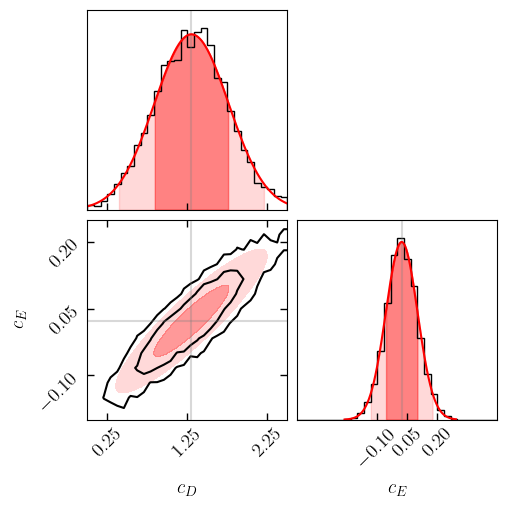

In [336]:
def sample_analyzer(sampler):
    
    def fit_samples(flat_samples):
        mv_fit = stats.multivariate_normal.fit(flat_samples)
        mv_means = mv_fit[0]
        mv_cov = mv_fit[1]
        mu_cD, mu_cE  = mv_means[0], mv_means[1]
        sigma_cD, sigma_cE = np.sqrt(mv_cov[0, 0]), np.sqrt(mv_cov[1, 1])

        mv_pdf = stats.multivariate_normal(mean=mv_means, cov=mv_cov)

        return mv_pdf, mu_cD, mu_cE, sigma_cD, sigma_cE

    def corner_contour(contour_ax, mv_pdf, mu_cD, mu_cE, sigma_cD, sigma_cE):

        pdf_68 = mv_pdf.pdf((mu_cD-sigma_cD, mu_cE-sigma_cE))
        pdf_95 = mv_pdf.pdf((mu_cD-2*sigma_cD, mu_cE-2*sigma_cE))

        x, y = np.mgrid[-5:5:.01, -5:5:.01]
        pos = np.dstack((x, y))
        pdf_values = mv_pdf.pdf(pos)

        mv_pdf_max = np.max(mv_pdf.pdf(pos))
        contourf_plot = contour_ax.contourf(x, y, mv_pdf.pdf(pos), levels=[pdf_95, pdf_68, mv_pdf_max], 
                                    colors=['r', 'r'], alpha=[0.15, 0.4])
        #contour_ax.contour(x, y, mv_pdf.pdf(pos), levels=[pdf_95, pdf_68], colors='k')

        xticks_cD, xticks_cE = [0.25, 1.25, 2.25], [-0.1, 0.05, 0.2]

        contour_ax.set_xlim(0, 2.5)
        contour_ax.set_ylim(-0.2, 0.25)
        contour_ax.set_xticks(xticks_cD)
        contour_ax.set_yticks(xticks_cE)
        contour_ax.yaxis.set_ticks_position('both')
        contour_ax.xaxis.set_ticks_position('both')
        contour_ax.tick_params(axis='both', direction='in', length=5, width=1, colors='black')

        contour_ax.axvline(mu_cD, color='gray', linestyle='-', alpha=0.3)
        contour_ax.axhline(mu_cE, color='gray', linestyle='-', alpha=0.3)

        return xticks_cD, xticks_cE, contour_ax.get_xlim()

    def plot_fit(ax, samples, mu, sigma):
        
        def fill(cred_region, alpha):

            lower = stats.norm.ppf(1-(1+cred_region)/2, mu, sigma)
            upper = stats.norm.ppf((1+cred_region)/2, mu, sigma)
            ax.fill_between(x, norm_pdf, where=((x >= lower) & (x <= upper)), 
                        color='r', alpha=alpha)

        ### Each 'poly' is a Polygon object; we can extract the vertices
        verts = ax.patches[0].get_xy()

        ### The x-values represent the bin edges, y-values represent the heights
        bin_left_edges = verts[:, 0]
        bin_heights = verts[:, 1]
        bin_width = np.diff(bin_left_edges)[1]

        ### Total histogram area
        area = np.sum(bin_width/2 * bin_heights)

        ### Generate the t-distribution PDF using the fitted parameters
        x = np.linspace(bin_left_edges.min(), bin_left_edges.max(), 1000)
        x = np.linspace(samples.min(), samples.max(), 1000)
        print(samples.min(), samples.max())
        norm_pdf = stats.norm.pdf(x, loc=mu, scale=sigma) * area

        ### Plot the t-distribution PDF over the histogram
        ax.axvline(mu, color='gray', linestyle='-', alpha=0.3)
        ax.plot(x, norm_pdf, 'r')
        
        fill(0.95, 0.15)
        fill(0.68, 0.4)

    def trace_plotter(iterations):
        fig_trace, ax_trace = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
        ax_trace[0].plot(sampler.chain[:, :iterations, 0].T, color='k', alpha=0.3)
        ax_trace[0].set_ylabel(r'$c_D$')
        ax_trace[1].plot(sampler.chain[:, :iterations, 1].T, color='k', alpha=0.3)
        ax_trace[1].set_ylabel(r'$c_E$')
        ax_trace[1].set_xlabel('Sampler Iteration')

    def t_test(flats_samples):
        cD_samples = flat_samples[:, 0]
        cE_samples = flat_samples[:, 1]
        df_cD, loc_cD, scale_cD = stats.t.fit(cD_samples)
        df_cE, loc_cE, scale_cE = stats.t.fit(cE_samples)
        data = {'df': [df_cD, df_cE], 'loc': [loc_cD, loc_cE], 'scale': [scale_cD, scale_cE]}
        print('t-distribution fit parameters:')
        df = pd.DataFrame(data, index=['cD', 'cE'])
        display(df)

    flat_samples = sampler.get_chain(discard=200, thin=1, flat=True)
    print('Number of samples: ', flat_samples.shape[0])
    fig = corner.corner(flat_samples, labels=[r"$c_D$", r"$c_E$"], color='k',
                    show_titles=False, bins=30, plot_contours=True, plot_datapoints=False, 
                    plot_density=False, levels=[0.68, 0.95], range=[(0, 2.5), (-0.5, 0.5)])

    #trace_plotter(iterations=15000)
    t_test(flat_samples)

    mv_pdf, mu_cD, mu_cE, sigma_cD, sigma_cE = fit_samples(flat_samples)

    contour_ax = fig.get_axes()[2]
    x_ticks_cD, x_ticks_cE, xlim = corner_contour(contour_ax, mv_pdf, mu_cD, mu_cE, sigma_cD, sigma_cE)

    for i in range(flat_samples.shape[1]):
        ### Diagonal indices of the corner plot
        ax = fig.get_axes()[i * (len(flat_samples[1]) + 1)]
        ax.tick_params(axis='both', direction='in', length=5, width=1, colors='black')
        if i == 0:
            ax.set_xticks(x_ticks_cD)
            ax.set_xlim(xlim[0], xlim[1])
            plot_fit(ax, flat_samples[:, i], mu_cD, sigma_cD)
        else:
            ax.set_xticks(x_ticks_cE)
            plot_fit(ax, flat_samples[:, i], mu_cE, sigma_cE)

    plt.show()

    return flat_samples

#sample_analyzer(sampler_2)
samples = sample_analyzer(sampler=sampler_4)

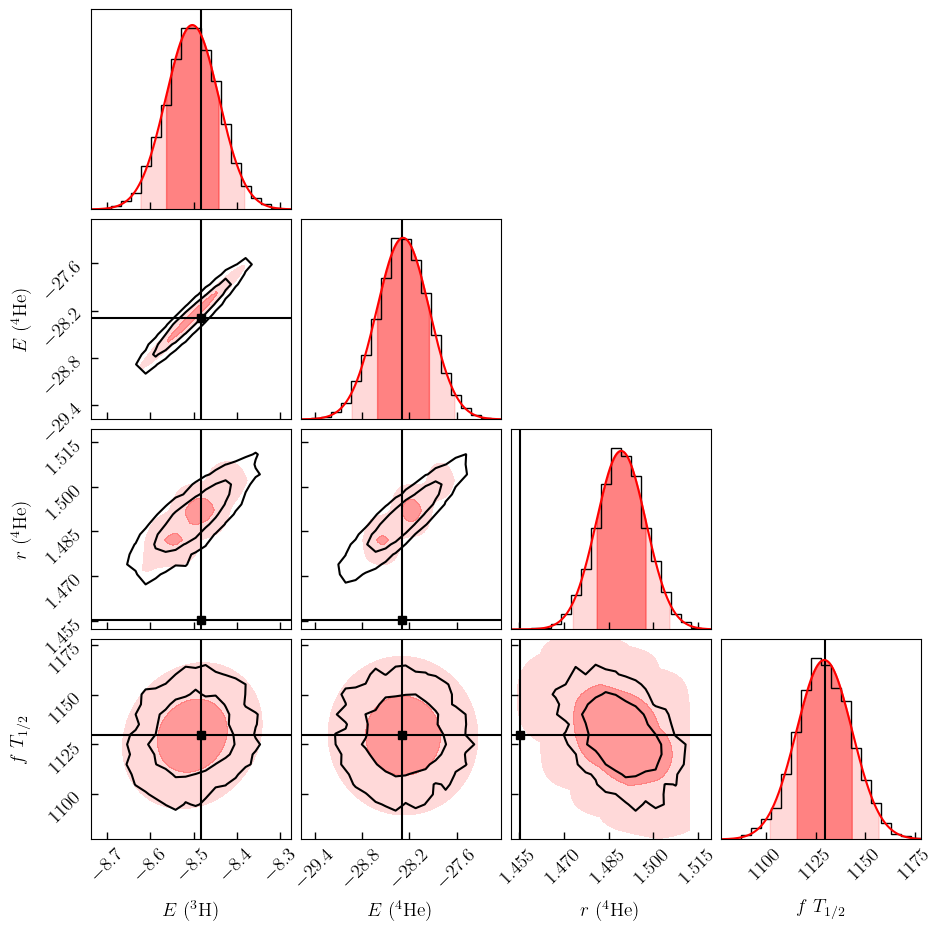

In [335]:
def fit_samples(flat_samples):

    mv_fit = stats.multivariate_normal.fit(flat_samples)
    mv_means = mv_fit[0]
    mv_cov = mv_fit[1]

    mv_pdf = stats.multivariate_normal(mean=mv_means, cov=mv_cov, allow_singular=True)

    return mv_means, mv_cov, mv_pdf

def plot_fit(ax, flat_samples, mu, sigma, mv_pdf, means, cov):
        
    def fill(cred_region, alpha):
        lower = stats.norm.ppf(1-(1+cred_region)/2, mu, sigma)
        upper = stats.norm.ppf((1+cred_region)/2, mu, sigma)
        ax.fill_between(x, norm_pdf, where=((x >= lower) & (x <= upper)), 
                    color='r', alpha=alpha)

    ### Each 'poly' is a Polygon object; we can extract the vertices
    verts = ax.patches[0].get_xy()

    ### The x-values represent the bin edges, y-values represent the heights
    bin_left_edges = verts[:, 0]
    bin_heights = verts[:, 1]
    bin_width = np.diff(bin_left_edges)[1]

    ### Total histogram area
    area = np.sum(bin_width/2 * bin_heights)

    ### Generate the t-distribution PDF using the fitted parameters
    x = np.linspace(bin_left_edges.min(), bin_left_edges.max(), 1000)

    # mu_3H, mu_4He, mu_Rp4He, mu_fT3H = means
    # sigma_3H, sigma_4He, sigma_Rp4He, sigma_fT3H = np.sqrt(np.diag(cov))
    # vals_3H = np.linspace(mu_3H - 3*sigma_3H, mu_3H + 3*sigma_3H, 100)
    # vals_4He = np.linspace(mu_4He - 3*sigma_4He, mu_4He + 3*sigma_4He, 100)
    # vals_Rp4He = np.linspace(mu_Rp4He - 3*sigma_Rp4He, mu_Rp4He + 3*sigma_Rp4He, 100)
    # vals_fT3H = np.linspace(mu_fT3H - 3*sigma_fT3H, mu_fT3H + 3*sigma_fT3H, 100)

    # marginalized_pdf = np.zeros_like(x)
    # for i, val in enumerate(vals_3H):
    #     for x1 in vals_4He:
    #         for x2 in vals_Rp4He:
    #             for x3 in vals_fT3H:
    #                 marginalized_pdf[i] += mv_pdf.pdf([val, x1, x2, x3])
    # print(marginalized_pdf)

    norm_pdf = stats.norm.pdf(x, loc=mu, scale=sigma) * area
    ### Plot the t-distribution PDF over the histogram
    ax.plot(x, norm_pdf, 'r')
    
    fill(0.95, 0.15)
    fill(0.68, 0.4)
    
def corner_contour(contour_ax, mv_pdf, mu, sigma, var_idx):

    # Extract the relevant variables (2D marginal distribution)
    mu_2d = np.array([mu[idx] for idx in var_idx])  # Mean for the two selected variables
    cov_2d = sigma[np.ix_(var_idx, var_idx)]  # Covariance for the selected variables

    # Define the multivariate normal for the 2D marginal
    mv_pdf_2d = stats.multivariate_normal(mean=mu_2d, cov=cov_2d)

    # Create a grid of points over which to evaluate the pdf
    x_min, x_max = contour_ax.get_xlim()
    y_min, y_max = contour_ax.get_ylim()
    x, y = np.mgrid[x_min:x_max:.01, y_min:y_max:.01]
    pos = np.dstack((x, y))

    # Evaluate the 2D pdf at the grid points
    pdf_values = mv_pdf_2d.pdf(pos)
    pdf_68 = mv_pdf_2d.pdf(mu_2d-np.sqrt(np.diag(cov_2d)))
    pdf_95 = mv_pdf_2d.pdf(mu_2d-2*np.sqrt(np.diag(cov_2d)))

    contour_ax.contourf(x, y, pdf_values, levels=[pdf_95, pdf_68, pdf_values.max()], 
                        colors=['r', 'r'], alpha=[0.15, 0.4])
    #contour_ax.contour(x, y, pdf_values, levels=[test_95, test_68], colors='k')

    return contour_ax

cD = samples[:,0]
cE = samples[:,1]

E4He, Rp4He, _, _, E3H, _, fT3H = vfewnucleonEmulator(cD, cE)

obs_values = np.array([E3H, E4He, Rp4He, fT3H])
means, cov, mv_pdf = fit_samples(obs_values.T)
sigmas = np.sqrt(np.diag(cov))

fig = corner.corner(obs_values.T, labels=[r"$E$ ($^3$H)", r"$E$ ($^4$He)", r"$r$ ($^4$He)", r"$f$ $T_{1/2}$"], color='k',
                    show_titles=False, bins=20, plot_contours=True, plot_datapoints=False, 
                    plot_density=False, levels=[0.68, 0.95], truths=[-8.482, -28.296, 1.4552, 1129.6], truth_color='k')

diag_indices = [0, 5, 10, 15]
contour_indices = [4, 8, 9, 12, 13, 14]
var_indices = [(0, 1), (0, 2), (1, 2), (0, 3), (1, 3), (2, 3)]
for i, ax in enumerate(fig.get_axes()):
    ax.tick_params(axis='both', direction='in', length=5, width=1, colors='black')
    if i in diag_indices:
        plot_fit(ax, obs_values[diag_indices.index(i)], means[diag_indices.index(i)], sigmas[diag_indices.index(i)], mv_pdf, means, cov)
    elif i in contour_indices:
        corner_contour(ax, mv_pdf, means, cov, var_idx=var_indices[contour_indices.index(i)])


In [358]:
def log_prior(params):

    cD, cE, Q = params[0], params[1], params[2]
    cD_mu = 0.
    cD_sigma = 5
    cE_mu = 0.
    cE_sigma = 5

    return (stats.norm.logpdf(cD, loc=cD_mu, scale=cD_sigma) + 
            stats.norm.logpdf(cE, loc=cE_mu, scale=cE_sigma) +
            stats.beta.logpdf(Q, a=3, b=5, loc=0, scale=1)) 

def log_likelihood(params):

    cD, cE, Q = params[0], params[1], params[2]
    
    if Q >= 1:
        return -np.inf

    E4He, Rp4He, _, _, E3H, _, fT3H = vfewnucleonEmulator(cD, cE)

    sigma_E3H = np.sqrt(0.015 + (1 * Q**4 * -8.482)**2/(1 - Q**2))
    sigma_E4He = np.sqrt(0.005 + (1 * Q**4 * -28.296)**2/(1 - Q**2))
    sigma_Rp4He = np.sqrt(0.0062 + (1 * Q**4 * 1.4552)**2/(1 - Q**2))
    sigma_fT3H = np.sqrt(3. + (1 * Q**4 * 1129.6)**2/(1 - Q**2))

    return (stats.norm.logpdf(-28.296, E4He, sigma_E4He) +
            stats.norm.logpdf(1.4552, Rp4He, sigma_Rp4He) +
            stats.norm.logpdf(-8.482, E3H, sigma_E3H) +
            stats.norm.logpdf(1129.6, fT3H, sigma_fT3H))

def log_posterior(params):
    return log_prior(params) + log_likelihood(params)

cD = np.random.normal(0., 5, 25)
cE = np.random.normal(0., 5, 25)
Q = np.random.beta(3, 5, 25)

pos = np.vstack((cD, cE, Q))
nwalkers, ndim = pos.T.shape

E4He, Rp4He, _, _, E3H, _, fT3H = vfewnucleonEmulator(cD, cE)

sampler_3d = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_posterior)
run_3d = sampler_3d.run_mcmc(pos.T, 500, progress=True)

100%|██████████| 500/500 [00:27<00:00, 17.94it/s]


In [359]:
flat_samples_3d = sampler_3d.get_chain(discard=200, thin=1, flat=True)
print('Number of samples: ', flat_samples_3d.shape[0])
# fig = corner.corner(flat_samples, labels=[r"$c_D$", r"$c_E$", r"Q"], color='k',
#                     show_titles=True, bins=30, plot_contours=True, plot_datapoints=False, 
#                     plot_density=False, levels=[0.68, 0.95])#, range=[(0, 2.5), (-0.5, 0.5), (0, 1)])


Number of samples:  7500


(np.float64(1.103153153153153), np.float64(1.4426426426426426)) (np.float64(0.8572072072072072), np.float64(1.6906906906906907))
(np.float64(-0.010280280280280288), np.float64(0.04983983983983983)) (np.float64(-0.0637937937937938), np.float64(0.10335335335335336))


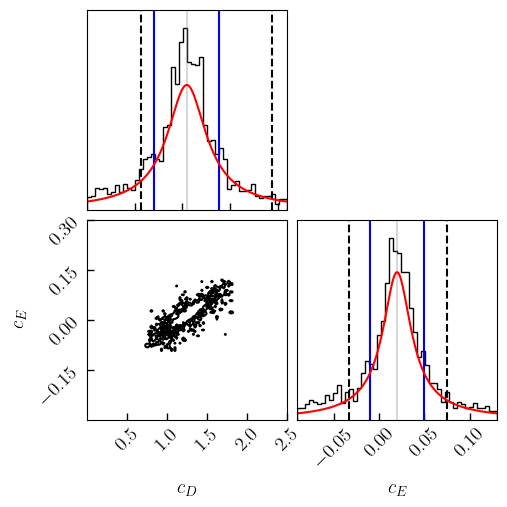

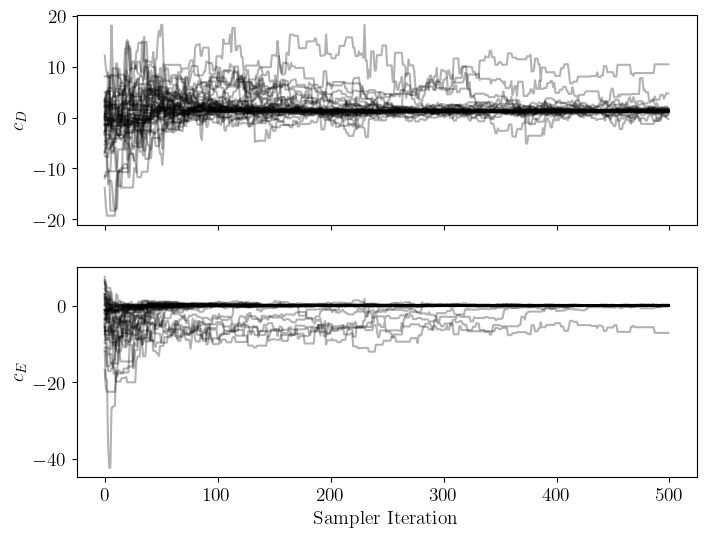

In [362]:
def sample_analyzer_error():
    
    def corner_contour(contour_ax, flat_samples, mv_pdf, mu_cD, mu_cE, sigma_cD, sigma_cE):

        pdf_68 = mv_pdf.pdf((mu_cD-sigma_cD, mu_cE-sigma_cE))
        pdf_95 = mv_pdf.pdf((mu_cD-2*sigma_cD, mu_cE-2*sigma_cE))

        x, y = np.mgrid[-5:5:.01, -5:5:.01]
        pos = np.dstack((x, y))
        pdf_values = mv_pdf.pdf(pos)

        mv_pdf_max = np.max(mv_pdf.pdf(pos))
        contourf_plot = contour_ax.contourf(x, y, mv_pdf.pdf(pos), levels=[pdf_95, pdf_68, mv_pdf_max], 
                                    colors=['r', 'r'], alpha=[0.15, 0.4])
        contour_ax.contour(x, y, mv_pdf.pdf(pos), levels=[pdf_95, pdf_68], colors='k')

        xticks_cD, xticks_cE = [0.25, 1.25, 2.25], [-0.1, 0.05, 0.2]

        contour_ax.set_xlim(0, 2.5)
        contour_ax.set_ylim(-0.2, 0.25)
        contour_ax.set_xticks(xticks_cD)
        contour_ax.set_yticks(xticks_cE)
        contour_ax.yaxis.set_ticks_position('both')
        contour_ax.xaxis.set_ticks_position('both')
        contour_ax.tick_params(axis='both', direction='in', length=5, width=1, colors='black')

        contour_ax.axvline(mu_cD, color='gray', linestyle='-', alpha=0.3)
        contour_ax.axhline(mu_cE, color='gray', linestyle='-', alpha=0.3)

        return xticks_cD, xticks_cE, contour_ax.get_xlim()

    def plot_fit(ax, flat_samples):
        
        def fill(cred_region, alpha):
            lower = stats.t.ppf(1-(1+cred_region)/2, mu, sigma)
            upper = stats.t.ppf((1+cred_region)/2, mu, sigma)
            ax.fill_between(x, norm_pdf, where=((x >= lower) & (x <= upper)), 
                        color='r', alpha=alpha)

        ### Each 'poly' is a Polygon object; we can extract the vertices
        verts = ax.patches[0].get_xy()

        ### The x-values represent the bin edges, y-values represent the heights
        bin_left_edges = verts[:, 0]
        bin_heights = verts[:, 1]
        bin_width = np.diff(bin_left_edges)[1]

        df, mu, sigma = stats.t.fit(flat_samples)
    
        ### Total histogram area
        area = np.sum(bin_width/2 * bin_heights)

        ### Generate the t-distribution PDF using the fitted parameters
        x = np.linspace(bin_left_edges.min(), bin_left_edges.max(), 1000) # Ändra
        #x = np.linspace(-100, 100, 1000) # Ändra

        norm_pdf = stats.t.pdf(x, df, loc=mu, scale=sigma) * area

        cumsum = np.cumsum(norm_pdf) / np.sum(norm_pdf)
        cred_68_low = x[np.argmin(np.abs(cumsum - 0.16))]
        cred_68_high = x[np.argmin(np.abs(cumsum - 0.84))]
        
        cred_95_low = x[np.argmin(np.abs(cumsum - 0.025))]
        cred_95_high = x[np.argmin(np.abs(cumsum - 0.975))]

        print((cred_68_low, cred_68_high), (cred_95_low, cred_95_high))

        ### Plot the t-distribution PDF over the histogram
        ax.axvline(mu, color='gray', linestyle='-', alpha=0.3)
        #ax.axvline(mu - sigma, color='k', linestyle='--')
        #ax.axvline(mu + sigma, color='k', linestyle='--')
        ax.axvline(cred_68_low, color='b', linestyle='-')
        ax.axvline(cred_68_high, color='b', linestyle='-')
        ax.plot(x, norm_pdf, 'r')
        
        #fill(0.86, 0.15)
        #fill(0.32, 0.4)

    def trace_plotter(iterations):
        fig_trace, ax_trace = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
        ax_trace[0].plot(sampler.chain[:, :iterations, 0].T, color='k', alpha=0.3)
        ax_trace[0].set_ylabel(r'$c_D$')
        ax_trace[1].plot(sampler.chain[:, :iterations, 1].T, color='k', alpha=0.3)
        ax_trace[1].set_ylabel(r'$c_E$')
        ax_trace[1].set_xlabel('Sampler Iteration')

    diag_indices = [0, 3]
    cEcD_contour_index = [2]
    for i, ax in enumerate(fig_onlyC.get_axes()):
        ax.tick_params(axis='both', direction='in', length=5, width=1, colors='black')
        if i in diag_indices:
            plot_fit(ax, samples_3d[:,diag_indices.index(i)])
        elif i in cEcD_contour_index:
            ax.set_xlim(0, 2.5)
            ax.set_ylim(-0.3, 0.3)
    trace_plotter(iterations=500)
    plt.show()

samples_3d = flat_samples_3d.reshape(-1, 3)
cD_samples, cE_samples, Q_samples = samples_3d[:,0], samples_3d[:,1], samples_3d[:,2]

fig_onlyC = corner.corner(samples_3d[:,:2], labels=[r"$c_D$", r"$c_E$"], color='k',
                        show_titles=False, bins=50, plot_contours=True, plot_datapoints=False, 
                        plot_density=False, levels=[0.68, 0.95], quantiles=[0.05, 0.16, 0.84, 0.95],
                        range=[(0.75, 1.8), (-0.09, 0.13)])

sample_analyzer_error()

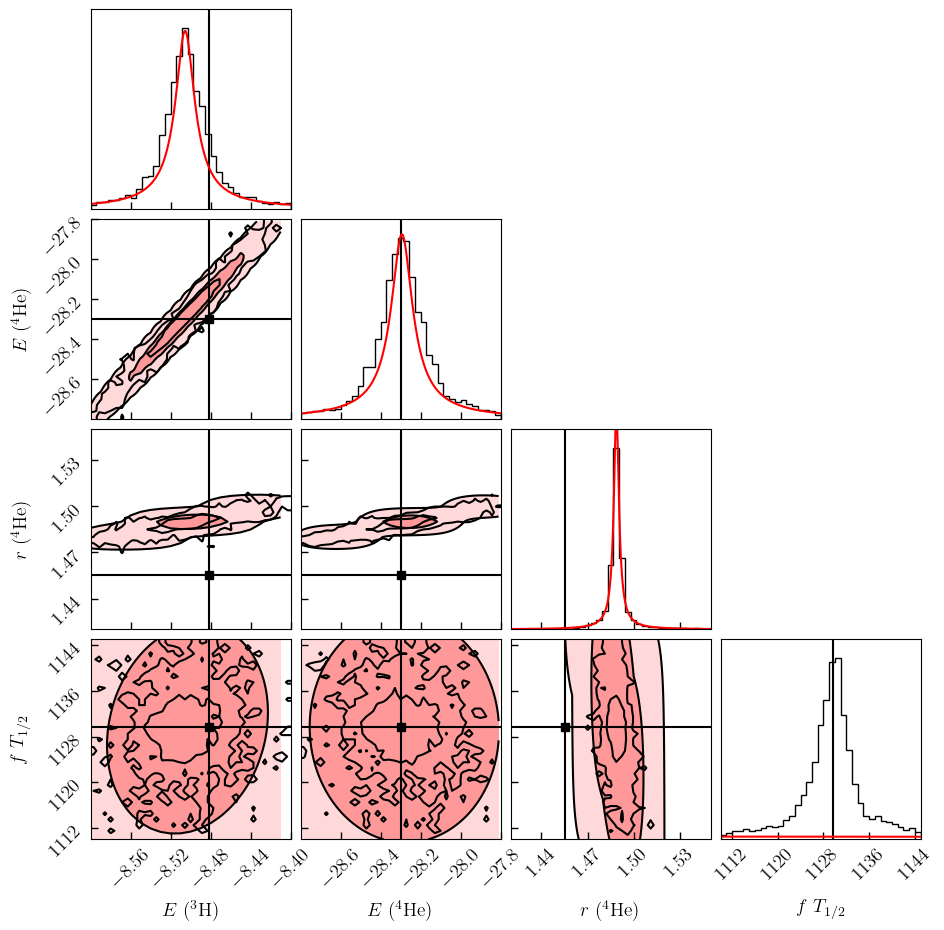

In [341]:
def fit_samples(flat_samples):

    df, loc, scale = stats.t.fit(flat_samples)

    return df, loc, scale

def plot_fit(ax, flat_samples, mu, sigma):
        
    def fill(cred_region, alpha):
        lower = stats.t.ppf(1-(1+cred_region)/2, mu, sigma)
        upper = stats.t.ppf((1+cred_region)/2, mu, sigma)
        ax.fill_between(x, t_pdf, where=((x >= lower) & (x <= upper)), 
                    color='r', alpha=alpha)

    ### Each 'poly' is a Polygon object; we can extract the vertices
    verts = ax.patches[0].get_xy()

    ### The x-values represent the bin edges, y-values represent the heights
    bin_left_edges = verts[:, 0]
    bin_heights = verts[:, 1]
    bin_width = np.diff(bin_left_edges)[1]

    ### Total histogram area
    area = np.sum(bin_width/2 * bin_heights)

    ### Generate the t-distribution PDF using the fitted parameters
    x = np.linspace(bin_left_edges.min(), bin_left_edges.max(), 1000)

    t_pdf = stats.t.pdf(x, loc=mu, scale=sigma, df=df) * area
    ### Plot the t-distribution PDF over the histogram
    ax.plot(x, t_pdf, 'r')
    
    #fill(0.95, 0.15)
    #fill(0.68, 0.4)
    
def corner_contour(contour_ax, mv_pdf, mu, sigma, var_idx):
    """
    Plot contours on the given axis for the 2D marginal distribution 
    of the multivariate normal distribution.
    
    contour_ax: Axis to plot on
    flat_samples: MCMC samples (for plotting points, optional)
    mv_pdf: multivariate pdf (e.g., from scipy.stats.multivariate_normal)
    mu: Mean of the multivariate normal distribution
    sigma: Covariance of the multivariate normal distribution
    var_idx: Indices of the two variables to plot (for 2D marginalization)
    """
    # Extract the relevant variables (2D marginal distribution)
    mu_2d = np.array([mu[idx] for idx in var_idx])  # Mean for the two selected variables
    cov_2d = sigma[np.ix_(var_idx, var_idx)]  # Covariance for the selected variables

    # Define the multivariate normal for the 2D marginal
    mv_pdf_2d = stats.multivariate_normal(mean=mu_2d, cov=cov_2d)

    # Create a grid of points over which to evaluate the pdf
    x_min, x_max = contour_ax.get_xlim()
    y_min, y_max = contour_ax.get_ylim()
    x, y = np.mgrid[x_min:x_max:.01, y_min:y_max:.01]
    pos = np.dstack((x, y))

    # Evaluate the 2D pdf at the grid points
    pdf_values = mv_pdf_2d.pdf(pos)
    test_68 = mv_pdf_2d.pdf(mu_2d-np.sqrt(np.diag(cov_2d)))
    test_95 = mv_pdf_2d.pdf(mu_2d-2*np.sqrt(np.diag(cov_2d)))
    
    # Plot contours for the 68% and 95% confidence intervals
    pdf_68 = np.percentile(pdf_values, 68)
    pdf_95 = np.percentile(pdf_values, 95)

    contour_ax.contourf(x, y, pdf_values, levels=[test_95, test_68, pdf_values.max()], 
                        colors=['r', 'r'], alpha=[0.15, 0.4])
    contour_ax.contour(x, y, pdf_values, levels=[test_95, test_68], colors='k')

    return contour_ax

cD = samples_3d[:,0]
cE = samples_3d[:,1]
#Q = samples[:,2]

E4He, Rp4He, _, _, E3H, _, fT3H = vfewnucleonEmulator(cD, cE)

obs_values = np.array([E3H, E4He, Rp4He, fT3H])

#means, cov, mv_pdf = fit_samples(obs_values.T)
#sigmas = np.sqrt(np.diag(cov))

fig = corner.corner(obs_values.T, labels=[r"$E$ ($^3$H)", r"$E$ ($^4$He)", r"$r$ ($^4$He)", r"$f$ $T_{1/2}$"], color='k',
                    show_titles=False, bins=35, plot_contours=True, plot_datapoints=False, 
                    plot_density=False, levels=[0.68, 0.95], truths=[-8.482, -28.296, 1.4552, 1129.6], truth_color='k',
                    range=[(-8.6, -8.4), (-28.8, -27.8), (1.420, 1.550), (1110, 1145)])

diag_indices = [0, 5, 10, 15]
contour_indices = [4, 8, 9, 12, 13, 14]
var_indices = [(0, 1), (0, 2), (1, 2), (0, 3), (1, 3), (2, 3)]
for i, ax in enumerate(fig.get_axes()):
    ax.tick_params(axis='both', direction='in', length=5, width=1, colors='black')
    if i in diag_indices:
        df, mu, sigma = fit_samples(obs_values[diag_indices.index(i)])
        plot_fit(ax, obs_values[diag_indices.index(i)], mu, sigma)
    elif i in contour_indices:
        corner_contour(ax, mv_pdf, means, cov, var_idx=var_indices[contour_indices.index(i)])
